#### Space Optimisation in Automated Storage and Retrieval Systems (ASRS) using Genetic Algorithm
The goal of space optimization in ASRS is to optimise the placement of items in a way that minimizes the travel time of retrieval robots, maximizes storage density, and improves overall system efficiency.

In [1]:
# spare cell to install packages


In [2]:
# import necessary libraries

import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# sample dataset

# layout of warehouse
warehouse_layout = (10, 10)

retrieval_requests = [
    {"item_id": 0, "frequency": 10},
    {"item_id": 1, "frequency": 5},
    {"item_id": 2, "frequency": 8},
    {"item_id": 3, "frequency": 2},
    {"item_id": 4, "frequency": 6},
    {"item_id": 5, "frequency": 3},
    {"item_id": 6, "frequency": 7},
    {"item_id": 7, "frequency": 4},
    {"item_id": 8, "frequency": 9},
    {"item_id": 9, "frequency": 1},
]


In [4]:
# initialise parameters

population_size = 20
num_generation = 50
crossover_rate = 0.8
mutation_rate = 0.1

In [5]:
# initialise population

def initialise_population():
    
    # each individual is a permutation of item IDs
    return [np.random.permutation(len(retrieval_requests)) for _ in range(population_size)]


In [6]:
# select best individuals (parents) based on their fitness scores

def selection(population, fitnesses):

    # combine population and fitnesses into a list of tuples
    combined = list(zip(population, fitnesses))
    
    # sort list by fitness in descending order
    sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
    
    # select the top individuals based on fitness
    
    '''
    In genetic algorithms, it's common to use only a portion of the current population as parents for generating the next generation. 
    Using half the population helps maintain a balance between exploration (trying out new solutions) and exploitation (refining existing good solutions).
    By taking the top half, you ensure that the individuals with the best fitness scores (i.e., the most optimal solutions found so far) are the ones 
    contributing their genes to the next generation.
    '''

    num_parents = population_size // 2
    selected = sorted_combined[:num_parents]
    
    # extract and return the individuals (without fitness scores) from the selected tuples
    return [ind for ind, fit in selected]

In [7]:
# crossover: creates two new individuals (children) by crossover combining parts of two parents

'''
Order crossover is a genetic algorithm crossover technique specifically designed for problems where the order of elements matters, 
such as the Traveling Salesman Problem (TSP) or sequencing problems. The primary goal of order crossover is to combine two parent 
solutions to produce offspring that preserve the relative ordering of the elements (genes) from the parents.
'''

def order_crossover(parent1, parent2):

    # children are initialized as lists of the same size as the parents, filled with -1 to indicate empty positions
    size = len(parent1)
    child1, child2 = [-1] * size, [-1] * size

    # randomly select two crossover points
    start, end = sorted(random.sample(range(size), 2))

    # copy the segment between the crossover points from parent1 to child1, and from parent2 to child2
    child1[start:end] = parent1[start:end]
    child2[start:end] = parent2[start:end]

    # fill_pos_1 and fill_pos_2 are set to end, indicating the next position to be filled in
    fill_pos_1, fill_pos_2 = end, end

    # loop through each item (gene) in parent2 to fill child1, and through parent1 to fill child2
    for gene in parent2:
        if gene not in child1:
            if fill_pos_1 >= size:
                fill_pos_1 = 0
            child1[fill_pos_1] = gene
            fill_pos_1 += 1
        if gene not in child2:
            if fill_pos_2 >= size:
                fill_pos_2 = 0
            child2[fill_pos_2] = gene
            fill_pos_2 += 1

    # return children as arrays
    return np.array(child1), np.array(child2)

In [8]:
# scramble mutation selects a subset of genes and randomly shuffles them to intoduce variation

def mutate(individual):

    # selects 2 random indices (sortetd makes sure that idx1 and idx2 are in ascending order)
    idx1, idx2 = sorted(random.sample(range(len(individual)), 2))

    # extracts subset of individual between indices
    subset = individual[idx1:idx2]

    # randomly reorders the elements within the extracted subset
    random.shuffle(subset)

    # replaces the original subset in the individual with the shuffled subset
    individual[idx1:idx2] = subset

In [9]:
# fitness function

def fitness_function(individual):

    # initialise
    fitness = 0
    retrieval_point = (0, 0)

    # creates a dictionary that maps each item ID to its position in the arrangement (individual)
    # this dictionary is created by pairing each item in individual with its index
    item_positions = {item_id: position for item_id, position in zip(individual, range(len(individual)))}

    # iterates over each retrieval request in retrieval_requests and for each request, it extracts the item_id and the frequency of retrieval
    for request in retrieval_requests:
        item_id = request["item_id"]
        frequency = request["frequency"]
        
        # error handling
        if item_id not in item_positions:
            print(f"Error: Item ID {item_id} not found in item_positions")
            continue

        # retrieves the position of the item from dictionary
        position = item_positions[item_id]

        # use divmod to convert the linear position into grid coordinates (x, y)
        # warehouse_layout[1] represents the number of columns in the warehouse grid
        x, y = divmod(position, warehouse_layout[1])

        # calculates the Manhattan distance (sum of the absolute differences between the coordinates) from the retrieval_point to the item's position
        distance = abs(x - retrieval_point[0]) + abs(y - retrieval_point[1])

        # update the fitness score by subtracting the product of the distance and frequency
        # larger distance or higher frequency results in a greater penalty (more negative value), indicating a less efficient arrangement

        # minimizing the distance traveled for retrieving items can significantly reduce time and operational costs - solutions with shorter retrieval distances are preferred
        # items requested more frequently should be placed closer to the retrieval point - frequently accessed items should require less travel time
        fitness -= distance * frequency
    
    return fitness

In [10]:
# genetic algorithm

def genetic_algorithm():

    # initialise
    population = initialise_population()
    best_fitnesses = []

    for generation in range(num_generation):

        # (1) calculate the fitness of each individual in the current population (2) find best best fitness score of current generation (3) append to list
        fitnesses = [fitness_function(ind) for ind in population]
        best_fitness = max(fitnesses)
        best_fitnesses.append(best_fitness)

        # selects best individuals (parents) from the current population based on their fitness scores
        parents = selection(population, fitnesses)

        # initialise empty list to hold the new population for the next generation
        new_population = []

        # runs until length of new pop equals to size of old pop, to ensure new population reaches desired size
        while len(new_population) < population_size:

            # randomly choose 2 parents from list of selected parents
            parent1, parent2 = random.sample(parents, 2)

            # applies crossover with a probability: 
            # if a random number is less than crossover_rate, the crossover function is applied to parent1 and parent2, producing child1 and child2
            # else, the children are just copies of the parent
            if random.random() < crossover_rate:
                child1, child2 = order_crossover(parent1, parent2)
            else:
                child1, child2 = parent1, parent2

            # applies mutation to child with a probability:
            # if a random number is less than mutation_rate, the mutate function is applied to child
            if random.random() < mutation_rate:
                mutate(child1)
            if random.random() < mutation_rate:
                mutate(child2)

            # adds the new children to the new population
            new_population.extend([child1, child2])

        # updates the population variable with the new generation
        # slicing to ensure that population size remains constant
        population = new_population[:population_size]

    # calculates the fitness of each individual in the final population
    fitnesses = [fitness_function(ind) for ind in population]

    # identifies best solution in final population
    best_solution = population[np.argmax(fitnesses)]
    return best_solution, best_fitnesses

In [11]:
# run the genetic algorithm

best_solution, best_fitnesses = genetic_algorithm()

In [12]:
# best solution and best fitnesses

print("Best solution:", best_solution)
print("Best fitnesses:", best_fitnesses)

Best solution: [8 2 4 5 6 1 0 9 7 3]
Best fitnesses: [-203, -203, -191, -191, -190, -182, -178, -182, -182, -194, -194, -198, -190, -190, -190, -191, -194, -206, -215, -208, -203, -203, -203, -197, -203, -191, -204, -180, -204, -183, -183, -199, -204, -202, -208, -196, -208, -195, -186, -182, -182, -172, -172, -172, -172, -172, -169, -169, -169, -177]


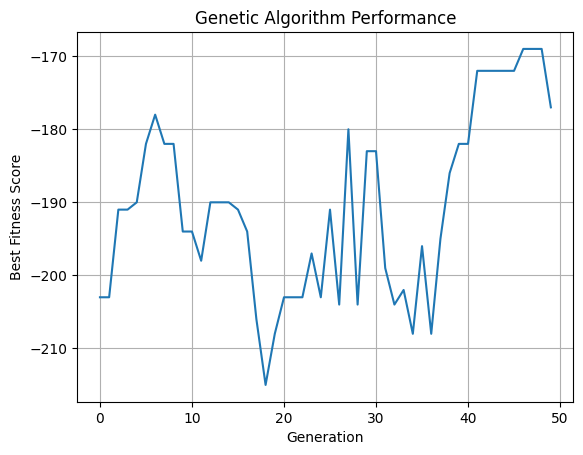

In [13]:
# plot the best fitness scores over generations

plt.plot(best_fitnesses)
plt.title('Genetic Algorithm Performance')
plt.xlabel('Generation')
plt.ylabel('Best Fitness Score')
plt.grid(True)

plt.show()

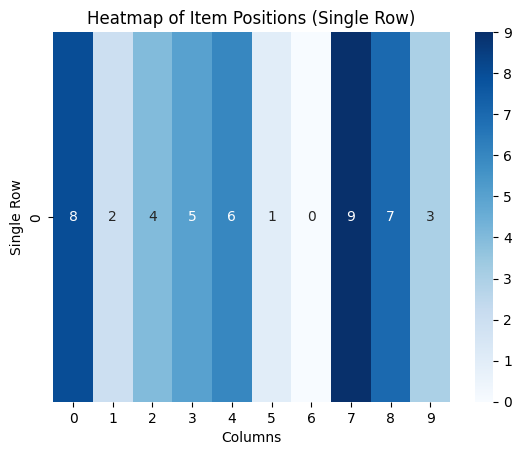

In [14]:
# heatmap of item positions: to visualize the positions of items in the warehouse grid

# best_solution has 10 elements and is to be reshaped as a 1D array
item_positions = np.array(best_solution).reshape((1, 10))  # reshape to a single row with 10 columns

sns.heatmap(item_positions, annot=True, cmap='Blues', cbar=True)
plt.xlabel('Columns')
plt.ylabel('Single Row')
plt.title('Heatmap of Item Positions (Single Row)')
plt.show()
